<a href="https://colab.research.google.com/github/Cospero/AI-Navmesh-test/blob/main/Kursovaya.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [943]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns


from sklearn.model_selection import train_test_split, cross_val_predict

from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.linear_model import Ridge
from sklearn.linear_model import ElasticNet
from sklearn.linear_model import PassiveAggressiveRegressor
from sklearn import linear_model
import xgboost as xgb

from sklearn import metrics
from sklearn import ensemble



import matplotlib.dates as mdates

from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

import time
from datetime import datetime, timedelta
!pip install https://github.com/matplotlib/mpl_finance/archive/master.zip
from mpl_finance import candlestick_ohlc


from sklearn.model_selection import GridSearchCV

import warnings
warnings.filterwarnings('ignore')

  Using cached https://github.com/matplotlib/mpl_finance/archive/master.zip
  Preparing metadata (setup.py) ... done


In [944]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [945]:
base_df = pd.read_csv('/content/drive/My Drive/Colab Notebooks/crypto-markets.csv')

In [946]:
filtred_df=base_df[base_df.name=="Bitcoin"]
display(filtred_df)

,slug,symbol,name,date,ranknow,open,high,low,close,volume,market,close_ratio,spread
0,bitcoin,BTC,Bitcoin,2013-04-28,1,135.30,135.98,132.10,134.21,0.000000e+00,1.488567e+09,0.5438,3.88
1,bitcoin,BTC,Bitcoin,2013-04-29,1,134.44,147.49,134.00,144.54,0.000000e+00,1.603769e+09,0.7813,13.49
2,bitcoin,BTC,Bitcoin,2013-04-30,1,144.00,146.93,134.05,139.00,0.000000e+00,1.542813e+09,0.3843,12.88
3,bitcoin,BTC,Bitcoin,2013-05-01,1,139.00,139.89,107.72,116.99,0.000000e+00,1.298955e+09,0.2882,32.17
4,bitcoin,BTC,Bitcoin,2013-05-02,1,116.38,125.60,92.28,105.21,0.000000e+00,1.168517e+09,0.3881,33.32
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2037,bitcoin,BTC,Bitcoin,2018-11-25,1,3880.78,4120.87,3585.06,4009.97,6.825640e+09,6.974927e+10,0.7930,535.81
2038,bitcoin,BTC,Bitcoin,2018-11-26,1,4015.07,4107.14,3643.92,3779.13,6.476900e+09,6.573929e+10,0.2919,463.22
2039,bitcoin,BTC,Bitcoin,2018-11-27,1,3765.95,3862.96,3661.01,3820.72,5.998720e+09,6.646897e+10,0.7908,201.95
2040,bitcoin,BTC,Bitcoin,2018-11-28,1,3822.47,4385.90,3822.47,4257.42,7.280280e+09,7.407256e+10,0.7720,563.43


In [947]:
filtred_df.isnull().any()

slug           False
symbol         False
name           False
date           False
ranknow        False
open           False
high           False
low            False
close          False
volume         False
market         False
close_ratio    False
spread         False
dtype: bool

In [948]:
filtred_df['date'] = pd.to_datetime(filtred_df['date'], format='%Y-%m-%d')

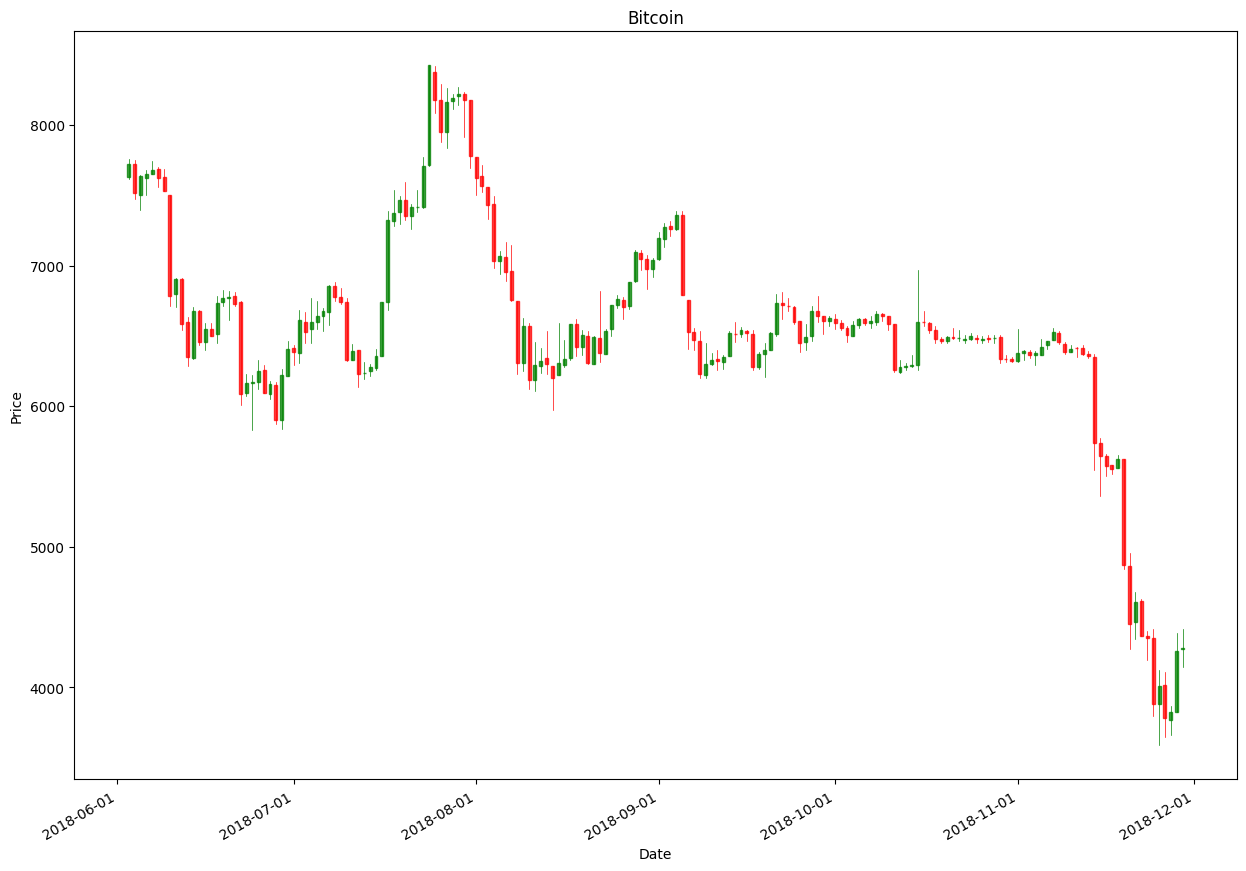

In [949]:
months=6

btc_price_df = filtred_df[(filtred_df['date'] > (max(filtred_df['date']) - timedelta(days=30*months)))]
OHLCfiltered_df = btc_price_df[['date','open','high','low','close']]
OHLCfiltered_df['date'] = mdates.date2num(OHLCfiltered_df['date'].dt.date)

f,ax=plt.subplots(figsize=(15,11))
ax.xaxis_date()
candlestick_ohlc(ax, OHLCfiltered_df.values, width=0.5, colorup='g', colordown='r',alpha=0.75)

plt.xlabel("Date")
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
plt.gcf().autofmt_xdate()
plt.title("Bitcoin")
plt.ylabel("Price")
plt.show()

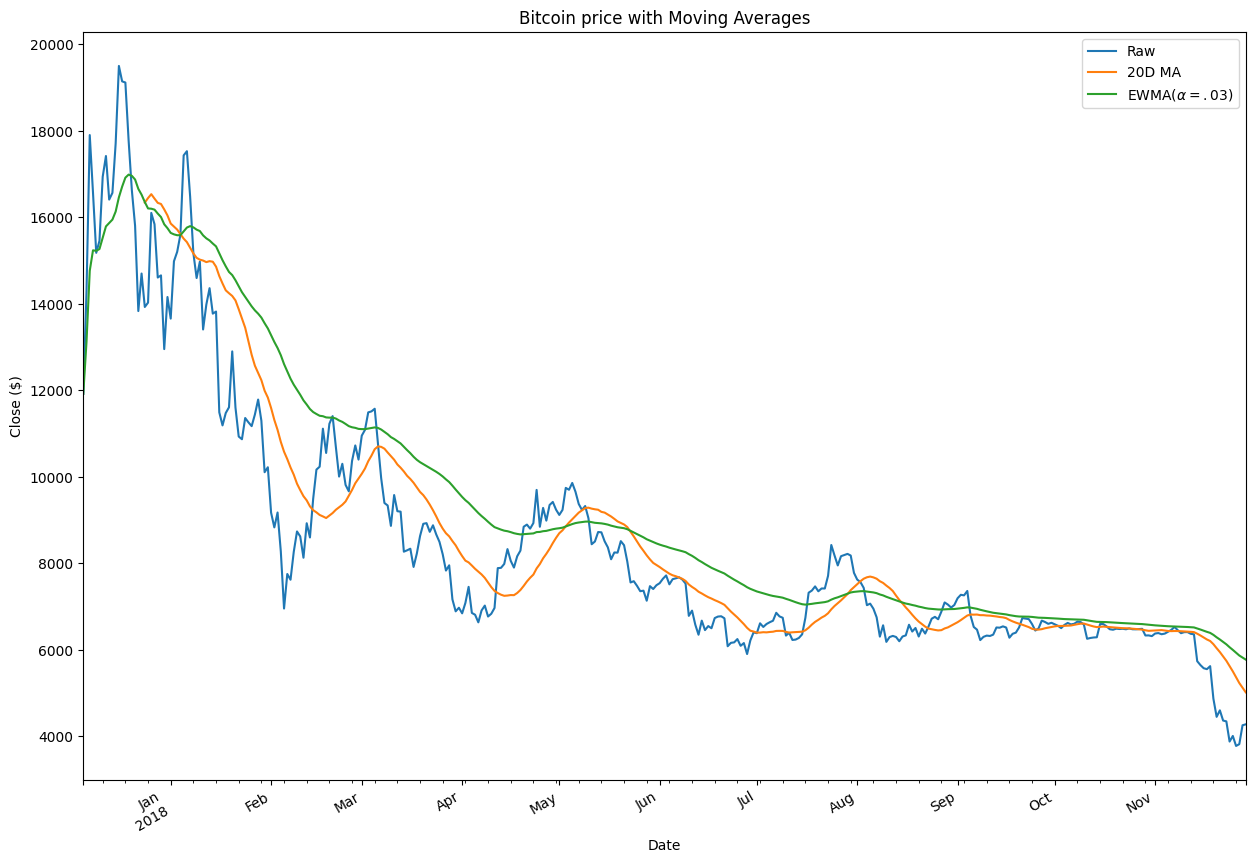

In [950]:
btc_priceMA_df = filtred_df[(filtred_df['date'] > (max(filtred_df['date']) - timedelta(days=30*12)))]

btc_priceMA_df.set_index('date', inplace=True)

f, ax = plt.subplots(figsize=(15,11))
btc_priceMA_df.close.plot(label='Raw', ax=ax)
btc_priceMA_df.close.rolling(20).mean().plot(label='20D MA', ax=ax)
btc_priceMA_df.close.ewm(alpha=0.03).mean().plot(label='EWMA($\\alpha=.03$)', ax=ax)

plt.title("Bitcoin price with Moving Averages")
plt.legend()
plt.xlabel("Date")
plt.gcf().autofmt_xdate()
plt.ylabel("Close ($)")
plt.show()

In [951]:
def Datapreperation():
    bitcoin_df = pd.DataFrame(filtred_df.loc[filtred_df.name =="Bitcoin", ["date", "open", "close", "high", "low"]]).set_index("date")
    bitcoin_df["close_nextday"] = bitcoin_df["close"].shift(periods = -1, fill_value = 0)
    temp = bitcoin_df[["open", "close", "high", "low"]]
    temp = temp[1800:]
    return bitcoin_df, temp

In [952]:
bitcoin_df, temp = Datapreperation()

In [953]:
bitcoin_df.head()

,open,close,high,low,close_nextday
date,,,,,
2013-04-28,135.30,134.21,135.98,132.10,144.54
2013-04-29,134.44,144.54,147.49,134.00,139.00
2013-04-30,144.00,139.00,146.93,134.05,116.99
2013-05-01,139.00,116.99,139.89,107.72,105.21
2013-05-02,116.38,105.21,125.60,92.28,97.75


In [954]:
def TestTrainpreperation(bitcoin_df):
    X = bitcoin_df[["open", "close", "high", "low"]]
    y = bitcoin_df[["close_nextday"]]
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
    return X_train, X_test, y_train, y_test

In [955]:
X_train, X_test, y_train, y_test = TestTrainpreperation(bitcoin_df)

model1 = LinearRegression()
model2 = DecisionTreeRegressor(max_depth=3)
model3 = KNeighborsRegressor(n_neighbors=3)
model4 = xgb.XGBRegressor(max_depth=3, n_estimators=100)
model5 = linear_model.TweedieRegressor(max_iter=800)
model6 = Ridge()

start_time = time.time()
model1.fit(X_train, y_train)
end_time = time.time()
model1_time = (end_time-start_time)


start_time = time.time()
model2.fit(X_train, y_train)
end_time = time.time()
model2_time = (end_time-start_time)


start_time = time.time()
model3.fit(X_train, y_train)
end_time = time.time()
model3_time = (end_time-start_time)


start_time = time.time()
model4.fit(X_train, y_train)
end_time = time.time()
model4_time = (end_time-start_time)


start_time = time.time()
model5.fit(X_train, y_train)
end_time = time.time()
model5_time = (end_time-start_time)


start_time = time.time()
model6.fit(X_train, y_train)
end_time = time.time()
model6_time = (end_time-start_time)



In [956]:
def CalculateMetrics(model_pdediction, score_df, model_name, time):
    score_df.at["r2_score", model_name]=metrics.r2_score(y_test,model_pdediction)
    score_df.at["mean_squared_error", model_name]=metrics.mean_squared_error(y_test,model_pdediction)
    score_df.at["mean_absolute_error", model_name]=metrics.mean_absolute_error(y_test,model_pdediction)
    score_df.at["model_fit_time", model_name]=time*1000


In [957]:
score = pd.DataFrame(index = ["r2_score", "mean_squared_error", "mean_absolute_error","model_fit_time"], columns= ["LinearRegression", "DecisionTreeRegressor", "KNeighborsRegressor", "XGBRegressor","TweedieRegressor", "Ridle"])

y_pred_model1 = model1.predict(X_test)
y_pred_model2 = model2.predict(X_test)
y_pred_model3 = model3.predict(X_test)
y_pred_model4 = model4.predict(X_test)
y_pred_model6 = model5.predict(X_test)
y_pred_model6 = model6.predict(X_test)




CalculateMetrics(y_pred_model1, score, "LinearRegression", model1_time)
CalculateMetrics(y_pred_model2, score, "DecisionTreeRegressor", model2_time)
CalculateMetrics(y_pred_model3, score, "KNeighborsRegressor", model3_time)
CalculateMetrics(y_pred_model4, score, "XGBRegressor", model4_time)
CalculateMetrics(y_pred_model6, score, "TweedieRegressor", model5_time)
CalculateMetrics(y_pred_model6, score, "Ridle", model6_time)


print(score)


                    LinearRegression DecisionTreeRegressor  \
r2_score                    0.996683              0.980276   
mean_squared_error      39704.600937         236064.824515   
mean_absolute_error        75.514402            256.256902   
model_fit_time             11.450291              4.921198   

                    KNeighborsRegressor  XGBRegressor TweedieRegressor  \
r2_score                       0.994018      0.992917         0.996683   
mean_squared_error         71592.671141  84776.827086     39704.598861   
mean_absolute_error           93.057129    107.718371        75.514401   
model_fit_time                 3.938198     40.557146         9.573936   

                            Ridle  
r2_score                 0.996683  
mean_squared_error   39704.598861  
mean_absolute_error     75.514401  
model_fit_time           2.854109  


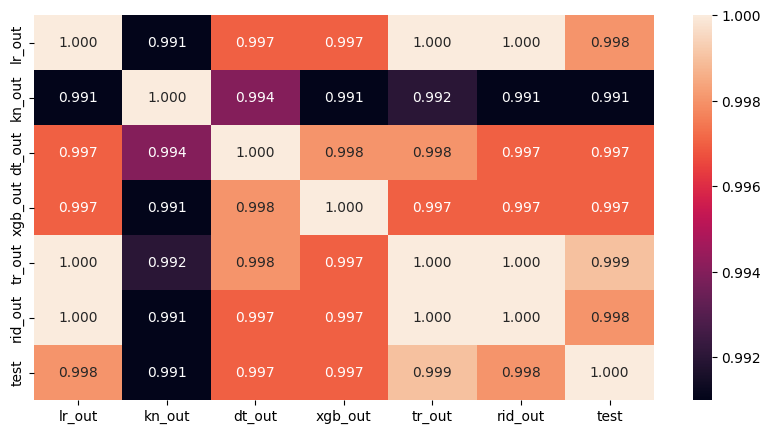

In [958]:
lr_out = y_pred_model1.squeeze()
kn_out = y_pred_model2.squeeze()
dt_out = y_pred_model3.squeeze()
xgb_out = y_pred_model4.squeeze()
tr_out=y_pred_model5.squeeze()
rid_out=y_pred_model6.squeeze()
y_test_out=y_test.squeeze()
stack_predict = np.vstack([lr_out,kn_out,dt_out,xgb_out,tr_out,rid_out,y_test_out]).T
corr_df = pd.DataFrame(stack_predict, columns=['lr_out','kn_out','dt_out','xgb_out','tr_out','rid_out','test'])
corr_matrix = corr_df.corr()
corr_matrix = corr_matrix.round(3)
plt.figure(figsize=(10,5))
sns.heatmap(corr_matrix, annot=True,  fmt=".3f")
plt.show()

In [959]:
X_train_meta = np.column_stack((
    cross_val_predict(model1, X_train, y_train, cv=3),
    cross_val_predict(model2, X_train, y_train, cv=3),
    cross_val_predict(model3, X_train, y_train, cv=3),
    cross_val_predict(model4, X_train, y_train, cv=3),

))

X_test_meta = np.column_stack((
    model1.predict(X_test),
    model2.predict(X_test),
    model3.predict(X_test),
    model4.predict(X_test),

))

meta_model = linear_model.MultiTaskLasso()
meta_model.fit(X_train_meta, y_train)

y_pred = meta_model.predict(X_test_meta)

mse = mean_squared_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print('MSE:', mse)
print('MAE:', mae)
print('R2:', r2)

results = pd.DataFrame(meta_model.predict(temp))
results = results.rename(columns={0: "Prediction"})
results = results.set_index(temp.index)
bitcoin_df = bitcoin_df.join(results, how = "left")


MSE: 36756.62323323904
MAE: 75.89673500839137
R2: 0.9969288389104558


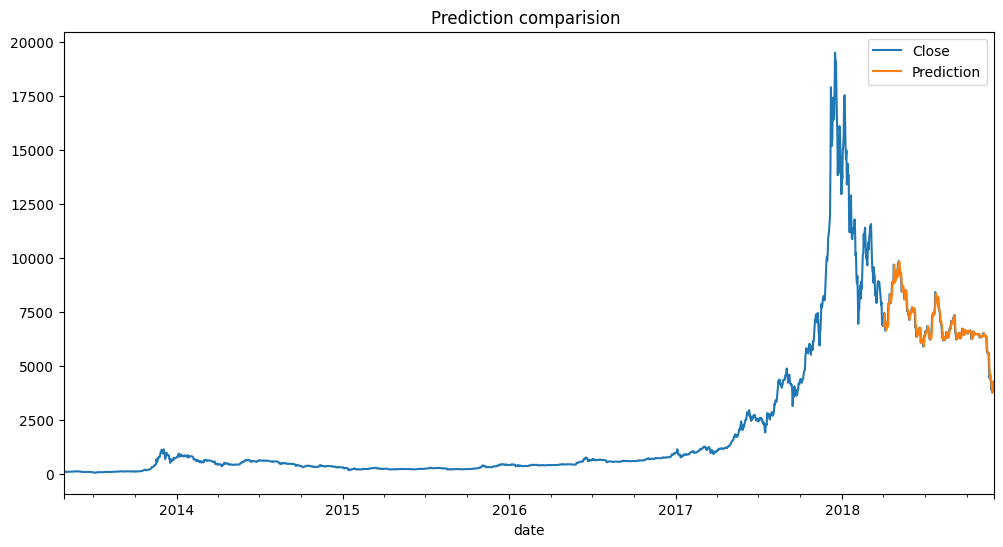

In [960]:
bitcoin_df['close'].plot(figsize=(12,6),label='Close',title = "Prediction comparision ")
bitcoin_df['Prediction'].plot(label='Prediction')
plt.legend()

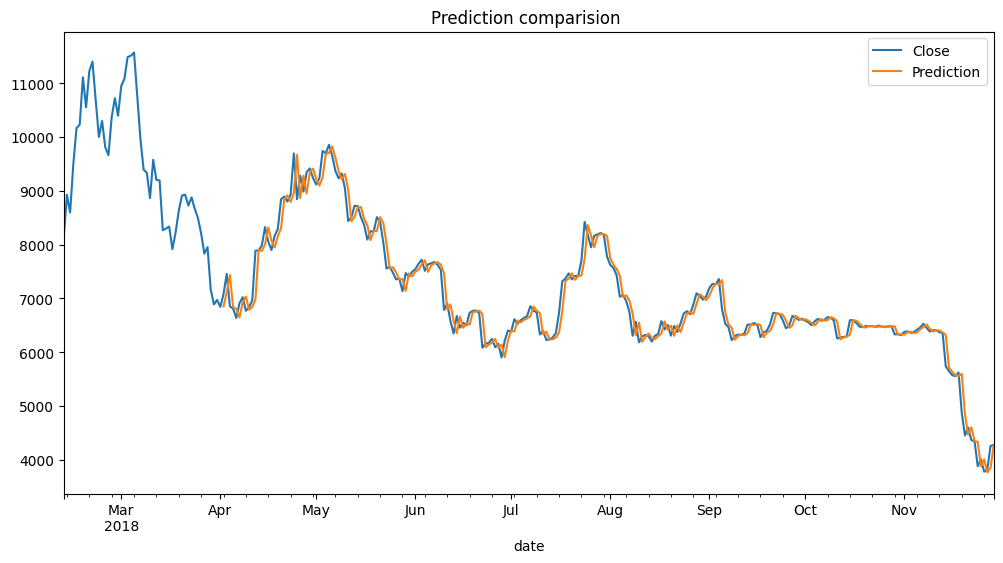

In [961]:
bitcoin_df1=bitcoin_df[1750:]
bitcoin_df1['close'].plot(figsize=(12,6),label='Close',title = "Prediction comparision ")
bitcoin_df1['Prediction'].plot(label='Prediction')
plt.legend()

MSE: 36734.284174052846
MAE: 74.92652580614147
R2: 0.9969307054271082


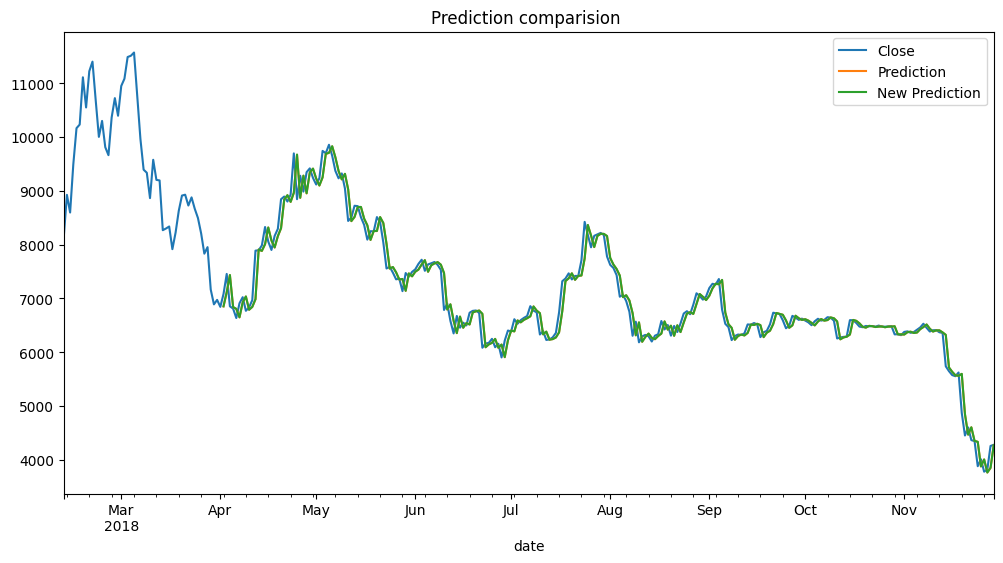

In [962]:
grid_params={
    'alpha': [0.1, 0.5, 1.0, 5.0, 10.0],
    'fit_intercept': [True, False],
    'max_iter': [1000, 5000, 10000]
}

meta_model2=linear_model.MultiTaskLasso()
grid_search = GridSearchCV(estimator=meta_model2, param_grid=grid_params, cv=5)

grid_search.fit(X_train_meta, y_train)

best_params=grid_search.best_params_

model3=linear_model.MultiTaskLasso(**best_params)
model3.fit(X_train_meta, y_train)

y_pred = model3.predict(X_test_meta)

mse = mean_squared_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print('MSE:', mse)
print('MAE:', mae)
print('R2:', r2)

results = pd.DataFrame(model3.predict(temp))
results = results.rename(columns={0: "New Prediction"})
results = results.set_index(temp.index)
bitcoin_df1 = bitcoin_df1.join(results, how = "left")

bitcoin_df1['close'].plot(figsize=(12,6),label='Close',title = "Prediction comparision ")
bitcoin_df1['Prediction'].plot(label='Prediction')
bitcoin_df1['New Prediction'].plot(label='New Prediction')
plt.legend()